In [2]:
library(dplyr)
library(Hmisc)     # for wtd.quantile if needed
library(ggplot2)
library(ggh4x)     # for facet_grid2() and strip_themed()
library(scales)    # for percent()
library(ggtext)    # for strip_themed (theme strip customization)
library(grid)      # for unit()
library(tidyr) 
library(reshape2)
library(data.table)

Warning message:
"Paket 'dplyr' wurde unter R Version 4.2.3 erstellt"

Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union


Lade nötiges Paket: lattice

Lade nötiges Paket: survival

Lade nötiges Paket: Formula

Lade nötiges Paket: ggplot2

Warning message:
"Paket 'ggplot2' wurde unter R Version 4.2.3 erstellt"

Attache Paket: 'Hmisc'


Die folgenden Objekte sind maskiert von 'package:dplyr':

    src, summarize


Die folgenden Objekte sind maskiert von 'package:base':

    format.pval, units


Warning message:
"Paket 'ggh4x' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'scales' wurde unter R Version 4.2.3 erstellt"

Attache Paket: 'reshape2'


Das folgende Objekt ist maskiert 'package:tidyr':

    smiths



Attache Paket: 'data.table'


Die folgenden Objekte sind maskiert von 'package:reshape2':

    dcast, melt


Die folge

### Timing of Policy Tipping Points

The functional lifespan of an adaptation measure ends when critical thresholds are crossed, requiring new interventions. This notebook uses exploratory modeling to estimate the timing of such tipping points under uncertainty. For each simulated future, the estimated year of critical conditions is recorded. The 5th percentile marks the earliest likely occurrence, offering a conservative estimate for proactive planning. The median indicates the most typical timing. Together, these values define a time window for potential policy failure, while the share of critical outcomes helps assess the reliability of this timing.

#### 1. Load cleaned datasets for East-Frisian focus area S15 | RCP8.5

In [3]:
data_s15_45 <- read.table("../model_output_M/model_output_S15_clean/out_S15_45.txt", sep = "\t", header = TRUE)
slr_data <- read.table('../figures/data/figure_3_data/regional_slr_ar5.txt', sep = '\t', header = TRUE)

#### 2. Create Policy Category Labels corresponding to Policy Levers $\text{L}$
Within the exploratory marsh accretion model, we assessed the impact of two management strategies on accretion dynamics: sand nourishment and vegetation management. Each strategy corresponds to a parameter in the dynamic accretion equation—sand nourishment influences the suspended sediment concentration $C$, while vegetation management affects the sediment trapping efficiency, expressed as the fraction of sediments depositing $f_d$. Each policy lever (e.g., nourishment frequency or vegetation intervention) is represented by a specific parameter value. To analyze potential policy lifespans, each simulated future state is labeled according to the applied combination of policy levers based on these parameter values.


In [11]:
policy_s15_45 <- data_s15_45  %>%
  filter(z_init == 0.7) %>%
  mutate(policy_category = case_when(
    c_flood_nourishment == 0.0 & fd == 0.4 ~ "No nourishment | Conservation",
    c_flood_nourishment %in% c(0.3, 0.5) & nourishment_frequency == 10 & fd == 0.4 ~ "Nourishment (10 years) | Conservation",
    c_flood_nourishment %in% c(0.3, 0.5) & nourishment_frequency == 5 & fd == 0.4 ~ "Nourishment (5 years) | Conservation",
    c_flood_nourishment %in% c(0.3, 0.5) & nourishment_frequency == 1 & fd == 0.4 ~ "Nourishment (annual) | Conservation",
    c_flood_nourishment == 0.0 & fd == 0.6 ~ "No Nourishment | Marsh Restoration",
    c_flood_nourishment %in% c(0.3, 0.5) & nourishment_frequency == 10 & fd == 0.6 ~ "Nourishment (10 years) | Marsh Restoration",
    c_flood_nourishment %in% c(0.3, 0.5) & nourishment_frequency == 5 & fd == 0.6 ~ "Nourishment (5 years) | Marsh Restoration",
    c_flood_nourishment %in% c(0.3, 0.5) & nourishment_frequency == 1 & fd == 0.6 ~ "Nourishment (annual) | Marsh Restoration",
    TRUE ~ "Unclassified"
  ))

#### 3. Policy Thresholds 
We defined vulnerability classes to indicate the likelihood of policy failure over time. Among them, the critical class (I) and the susceptible class (II) signal that a policy is approaching or has reached a policy tipping point. These classes are determined by the critical year—the point in time when sea level exceeds surface elevation.

For each aggregated policy category, we first calculate the percentage of model runs assigned to classes I and II. Within this subset, we then estimate the 5th and 50th percentiles of the critical year distribution. These percentiles provide lower-bound and median estimates of policy thresholds under uncertain environmental conditions.


``cy_early: 5 percentile of critical years per policy category``
- Shortest potential policy lifespan/ earliest critical policy threshold 
- first occurence of critical conditions under a given policy across the distribution of scenarios. 
- Conservative estimate of when criticality may begin, lower bound for proative decision making


``cy_central: 50 percentile of critical years per policy category``
- measure of central tendency, highlighting the typical timing of critical conditions. 

``slr_mode``
- most frequently occurring slr_select value (the mode) among all cases within a policy category where the estimated critical year is before 2120.

``slr_mode_perc``
- percentage of critical policies that share the slr_mode.

In [5]:
policy_agg_s15_45 <- policy_s15_45 %>%
  group_by(policy_category) %>%
  summarise(
    policy_count = n(),
    critical_count = sum(est_crit_year < 2120, na.rm = TRUE),
    percentage = round(critical_count * 100 / policy_count, 0),
    cy_early = round(quantile(est_crit_year[est_crit_year < 2120], 0.05, na.rm = TRUE)),
    cy_central = round(quantile(est_crit_year[est_crit_year < 2120], 0.5, na.rm = TRUE)),
    slr_mode = {
      tbl <- table(slr_select[est_crit_year < 2120])
      as.integer(names(which.max(tbl)))
    },
    slr_mode_perc = {
      tbl <- table(slr_select[est_crit_year < 2120])
      round(100 * max(tbl) / sum(tbl), 0)
    }
  ) %>%
  ungroup()


Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `slr_mode_perc = { ... }`.
ℹ In group 8: `policy_category = "Nourishment (annual) | Marsh Restoration"`.
Caused by warning in `max()`:
! kein nicht-fehlendes Argument für max; gebe -Inf zurück"
Warning message:
"Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame
  and adjust accordingly."
`summarise()` has grouped output by 'policy_category'. You can override using the `.groups` argument.


Ordering of policies by critical percentage.

In [6]:
policy_order <- c(
  "No nourishment | Conservation",
  "Nourishment (10 years) | Conservation",
  "Nourishment (5 years) | Conservation",
  "No Nourishment | Marsh Restoration",
  "Nourishment (10 years) | Marsh Restoration",
  "Nourishment (5 years) | Marsh Restoration",
  "Nourishment (annual) | Conservation",
  "Nourishment (annual) | Marsh Restoration"
)

policy_agg_s15_45 <- policy_agg_s15_45 %>%
  mutate(order_col = match(policy_category, policy_order)) %>%
  arrange(order_col, desc(percentage), desc(policy_count)) %>%
  select(-order_col)

In [7]:
policy_agg_s15_45

policy_category,policy_count,critical_count,percentage,cy_early,cy_central,slr_mode,slr_mode_perc
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
No nourishment | Conservation,54,20,37,2068,2090,3,70
Nourishment (10 years) | Conservation,108,37,34,2070,2100,3,76
Nourishment (5 years) | Conservation,90,25,28,2077,2101,3,88
No Nourishment | Marsh Restoration,54,14,26,2071,2096,3,79
Nourishment (10 years) | Marsh Restoration,108,25,23,2078,2105,3,88
Nourishment (5 years) | Marsh Restoration,90,13,14,2086,2107,3,100
Nourishment (annual) | Conservation,72,1,1,2115,2115,3,100


#### 4. Join with Sea Level Rise Data
Sea level is the primary driver of system dynamics in the model. To link policy lifespans with sea level thresholds, we extract the sea level values corresponding to the earliest and median estimated critical years for each policy category.

``slr_max_early: projected sea level at year 'cy_early'``  
``slr_max_central: projected sea level at year 'cy_central'``

Values are derived from the 95th percentile sea level rise projection to represent a high-end scenario. This choice is based on the ``slr_mode`` and ``slr_mode_perc`` values and aims to provide a conservative estimate.

``slr_mean_early: projected sea level at year 'cy_early'``  
``slr_mean_central: projected sea level at year 'cy_central'``

Values derived from the 50th percentile sea level rise projection to represent a central estimate and thus a moderate or most likely scenario.

In [8]:
dapp_s15_45 <- policy_agg_s15_45 %>%
  left_join(slr_data %>% select(year, max_45), by = c("cy_early" = "year")) %>%
  rename(slr_max_early = max_45) %>%
  left_join(slr_data %>% select(year, max_45), by = c("cy_central" = "year")) %>%
  rename(slr_max_central = max_45)%>%
  mutate(RCP = "RCP 4.5")

The plotting range is the period ``2041-2100``. All values for ``cy_central`` outside this period can not be plotted, so they need to be replace by ``2100```.

In [24]:
dapp_s15_45 <- dapp_s15_45 %>%
  filter(cy_early <= 2100) %>%
  mutate(cy_central_cut = ifelse(cy_central > 2100, 2100, cy_central))

In [9]:
dapp_s15_45 <- dapp_s15_45 %>%
  mutate(cy_central_cut = ifelse(cy_central > 2100, 2100, cy_central)) %>%

In [31]:
dapp_s15_45[c( "policy_category", "slr_max_early", "percentage")] 

policy_category,slr_max_early,percentage
<chr>,<dbl>,<dbl>
No nourishment | Conservation,0.5224,37
Nourishment (10 years) | Conservation,0.5419,34
Nourishment (5 years) | Conservation,0.6069,28
No Nourishment | Marsh Restoration,0.5510,26
Nourishment (10 years) | Marsh Restoration,0.6170,23
Nourishment (5 years) | Marsh Restoration,0.6955,14


#### 5. Assignment of policy category to Sea Level thresholds
Based on the earliest onset of critical conditions for policy effectiveness, the ``slr_max_early`` value is used to assign policy categories to sea level rise (SLR) bandwidth groups. 
The offset is introduced for adjusting the vertical positions of the plot elements.

In [32]:
# Directly define threshold values based on the slr_max_early column
threshold_vals <- c("0.5", "0.5", "0.6", "0.5", "0.6",  "0.6")

# To control plotting order, the factor column threshold_f with the threshold values as levels is defined
dapp_s15_45 <- dapp_s15_45 %>%
  mutate( threshold_f = factor(threshold_vals, levels = c("0.8", "0.6", "0.5"))) %>%
  group_by(threshold_f) %>%
  mutate( threshold_offset = as.numeric(factor(policy_category, levels = unique(policy_category)))) %>%
  ungroup()

In [33]:
# Define the color palette for policies
palette_policy <- c(
  'No nourishment | Conservation' = '#604611',
  'Nourishment (10 years) | Conservation' = '#F4C542',
  'Nourishment (5 years) | Conservation' = '#DDA63A',
  'Nourishment (annual) | Conservation' = '#7D5A15',
  'No Nourishment | Marsh Restoration' = '#D2EF3F',
  'Nourishment (10 years) | Marsh Restoration' = '#8FC36B',
  'Nourishment (5 years) | Marsh Restoration' = '#3F7E44',
  'Nourishment (annual) | Marsh Restoration' = '#015CAF'
)

In [34]:
policy_lifespan_45 <- ggplot(dapp_s15_45) +
    # opaque segment marking central estimate
    geom_segment(
    aes(x = cy_central - 0.4,  xend = cy_central,
        y = threshold_offset, yend = threshold_offset, color = policy_category
        ), 
    size = 5
  ) + 
  # range (alpha=0.4) from early to central estimate for policy threshold
  geom_segment(
    aes(x = cy_early, xend = cy_central_cut, y = threshold_offset, 
        yend = threshold_offset, color = policy_category
        ),
    size = 5, alpha = 0.4
  ) +
  geom_text(
    aes(x = 2042, y = threshold_offset, label = paste0(percentage, "%")),
    size = 5, color = "black",hjust = 1,vjust = 0.5
  ) +
  geom_text(
    aes(x = cy_early - 1, y = threshold_offset, label = as.character(cy_early)),
    color = "black", size = 5, hjust = 1
  ) +
  geom_text(aes(x = cy_central_cut - 1, y = threshold_offset, label = as.character(cy_central)),
    color = "white",fontface = "bold", size = 5, hjust = 1
  ) +
  scale_color_manual(values = palette_policy) +
  facet_grid2(
    threshold_f ~ ., scales = "free_y", switch = "y", strip = strip_themed(background_y = elem_list_rect(
        fill = c(rep(c("#B4B6D3"), 4)),color = rep("transparent", 4)
      ),
      text_y = elem_list_text(colour = c(rep("#FFFFFF", 4)),by_layer_y = FALSE))
  ) +
  labs(
    x = NULL, 
    y = "SLR threshold", 
    color = "Policy"
  ) +
  theme_bw() +
  theme(
    legend.title = element_blank(),
    strip.text.y = element_text(size = 20),
    strip.background = element_rect(fill = NA, colour = "black"),
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 20),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.position = "bottom",
    legend.text = element_text(size = 16),
    legend.key.width = unit(2, "cm"),
    legend.key.size = unit(0.5, "cm"),
    plot.title = element_text(size = 25, face = "bold"),
    plot.subtitle = element_text(size = 23, face = "italic"),
    plot.caption = element_text(size = 17),
    axis.title.y = element_text(hjust = 0.5, size = 20),
    axis.text.y = element_blank(),
    panel.spacing = unit(0.5, "lines")
  ) +
  guides(colour = guide_legend(ncol = 2)) +
  scale_x_continuous(
    limits = c(2040, 2100),
    breaks = seq(2040, 2100, by = 10),
    labels = seq(2040, 2100, by = 10)
  ) +
  scale_y_continuous(expand = expansion(mult = c(0.2, 0.2)))

Warning message:
"Removed 3 rows containing missing values or values outside the scale range (`geom_segment()`)."


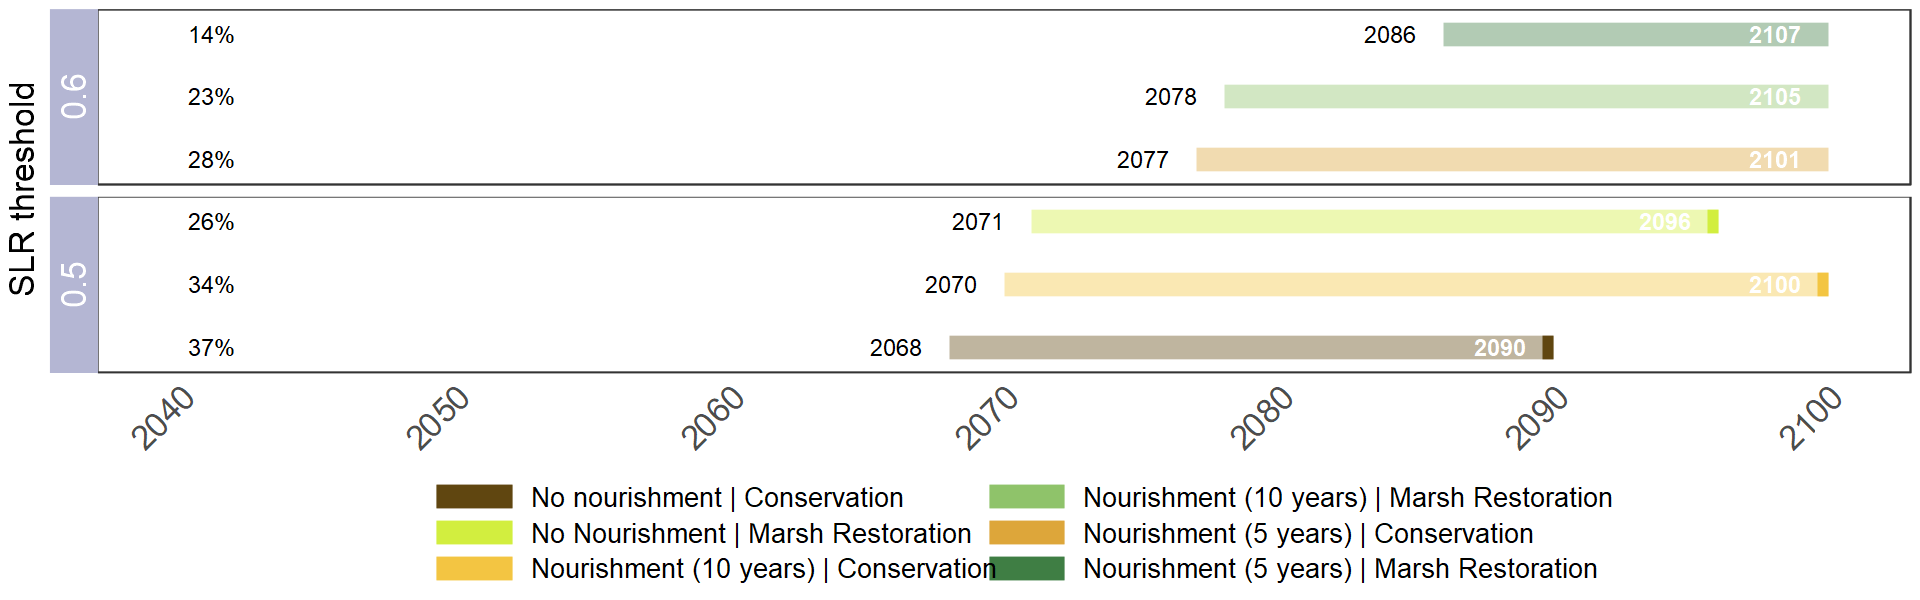

In [35]:
options(repr.plot.width = 16, repr.plot.height = 5)
print(policy_lifespan_45)